In [2]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# Preprocessing

In [3]:
df = pd.read_csv('/home/jupyter/Data_files/data_w_entry_prod_price_no_outliers_03_22_23.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

cols_to_clip = ['outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct', 'drinkware_pct', 'hard_cooler_pct']
df[cols_to_clip] = df[cols_to_clip].clip(lower=0)

# Encoding
df_encoded = pd.get_dummies(df, columns=['unsubscribed'])
df_encoded.describe()  

,avg_time_btw_orders,recency,months_elapsed,purchase_times,lifetime_spent,lifetime_quantity,per_order_spent,per_order_quantity,distinct_category_count,discount_frequency_order,...,customizer_completed_count,cart_viewed_count,checkout_started_count,order_cancelled_count,email_received,email_open_rate,max_entry_product_price,unsubscribed_0.0,unsubscribed_1.0,unsubscribed_2.0
count,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,...,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06,1.705094e+06
mean,1.026542e+01,1.388923e+01,3.411987e+01,3.808823e+00,4.617960e+02,1.552038e+01,1.170264e+02,4.028819e+00,2.173876e+00,2.588554e-01,...,2.210214e+00,1.297433e+01,6.056635e+00,3.399871e-02,2.797273e+03,4.405179e-01,7.364785e+01,6.830603e-01,1.767164e-01,1.402234e-01
std,1.196826e+01,1.010152e+01,1.958098e+01,3.999373e+00,1.029071e+03,3.949848e+01,2.092002e+02,9.741041e+00,1.021570e+00,3.522186e-01,...,6.264602e+00,2.825952e+01,1.090354e+01,2.362945e-01,5.845097e+03,3.074722e-01,1.045439e+02,4.652838e-01,3.814286e-01,3.472187e-01
min,0.000000e+00,7.333333e-01,7.666667e-01,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.541667e+00,5.166667e+00,1.966667e+01,2.000000e+00,1.049700e+02,4.000000e+00,4.150000e+01,1.500000e+00,2.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,1.200000e+02,1.542056e-01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.391667e+00,1.193333e+01,3.103333e+01,3.000000e+00,2.100000e+02,7.000000e+00,6.499333e+01,2.333333e+00,2.000000e+00,0.000000e+00,...,0.000000e+00,6.000000e+00,3.000000e+00,0.000000e+00,1.164000e+03,4.269316e-01,3.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.310000e+01,2.053333e+01,4.443333e+01,4.000000e+00,4.599700e+02,1.300000e+01,1.302375e+02,3.500000e+00,3.000000e+00,5.000000e-01,...,2.000000e+00,1.400000e+01,7.000000e+00,0.000000e+00,3.090000e+03,6.666667e-01,4.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00
max,1.056333e+02,1.078667e+02,1.082333e+02,1.000000e+02,4.000000e+04,9.990000e+02,1.932448e+04,4.725000e+02,7.000000e+00,1.000000e+00,...,7.510000e+02,4.248000e+03,2.272000e+03,5.400000e+01,6.733020e+05,1.000000e+00,1.500000e+03,1.000000e+00,1.000000e+00,1.000000e+00


# EDA

## Look at frequency & recency distribution before scaling


count   1705094.00
mean         10.27
std          11.97
min           0.00
25%           2.54
50%           6.39
75%          13.10
max         105.63
Name: avg_time_btw_orders, dtype: float64
count   1705094.00
mean         13.89
std          10.10
min           0.73
25%           5.17
50%          11.93
75%          20.53
max         107.87
Name: recency, dtype: float64


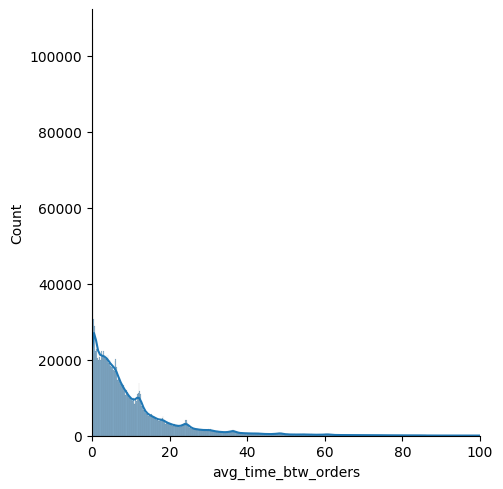

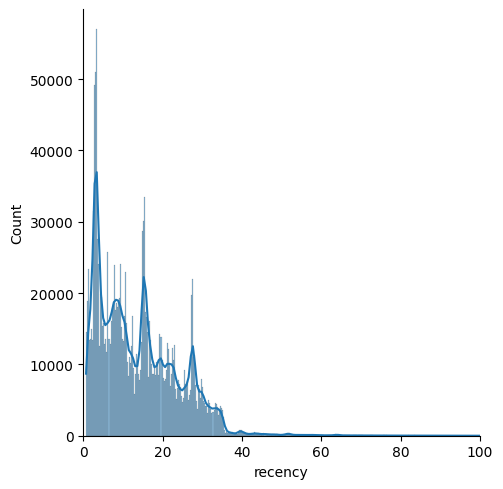

In [4]:
from tabulate import tabulate

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df['avg_time_btw_orders'].describe())
print(df['recency'].describe())

# Create the distribution plot
sns.displot(df['avg_time_btw_orders'], kde=True).set(xlim=(0, 100))
sns.displot(df['recency'], kde=True).set(xlim=(0,100))


## Sampling & Scaling

In [5]:
# randomly sample  rows from the dataframe
df2 = df_encoded.copy()#.sample(n=500000, random_state=21)

# Specify columns to standardize
cols_to_standardize1 = [ 'avg_time_btw_orders', 'recency', 'months_elapsed',
       'purchase_times', 'lifetime_spent', 'lifetime_quantity',
       'per_order_spent', 'per_order_quantity', 'distinct_category_count',
       'discount_frequency_order', 'discount_frequency_product','max_entry_product_price',
              
       'outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct',
       'drinkware_pct', 'hard_cooler_pct', 'other_pct']
    
cols_to_standardize2=[                         
        'black_pct', 'white_pct', 'navy_pct', 'seaform_pct', 'stainless_pct', 'charcoal_pct',
       'nordic_purple_pct', 'harvest_red_pct', 'alpine_yellow_pct',
       'other_color_pct', 
                       
        'product_added_count',
       'product_added_to_wishlist_count', 'product_removed_count',
       'customizer_started_count', 'customizer_completed_count',
       'cart_viewed_count', 'checkout_started_count', 'order_cancelled_count',
       'email_received', 'email_open_rate', 
       'unsubscribed_0.0', 'unsubscribed_1.0', 'unsubscribed_2.0']

#Log Transformation 
# cols_to_log = [ 'avg_time_btw_orders', 'recency']
# df2[cols_to_log] = df2[cols_to_log].apply(lambda x: np.log(x+1))


# Create a Scaler object
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit and transform the specified columns using the StandardScaler object
df2[cols_to_standardize1] = scaler1.fit_transform(df2[cols_to_standardize1])
df2[cols_to_standardize2] = scaler2.fit_transform(df2[cols_to_standardize2])




# PCA

In [6]:
# Exclude frequency ,recency, email interactions, web actions
cols_to_PCA=[  'months_elapsed',
       'purchase_times', 'lifetime_spent', 'lifetime_quantity',
       'per_order_spent', 'per_order_quantity', 'distinct_category_count',
       'discount_frequency_order', 'discount_frequency_product','max_entry_product_price',
                       
       'outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct',
       'drinkware_pct', 'hard_cooler_pct', 'other_pct', 
                       
       #  'black_pct', 'white_pct', 'navy_pct', 'seaform_pct', 'stainless_pct', 'charcoal_pct',
       # 'nordic_purple_pct', 'harvest_red_pct', 'alpine_yellow_pct',
       # 'other_color_pct', 
                       
       #  'product_added_count',
       # 'product_added_to_wishlist_count', 'product_removed_count',
       # 'customizer_started_count', 'customizer_completed_count',
       # 'cart_viewed_count', 'checkout_started_count', 'order_cancelled_count',
       # 'email_received', 'email_open_rate', 
       # 'unsubscribed_0.0', 'unsubscribed_1.0', 'unsubscribed_2.0'
            ]
             
# Perform PCA on the data
pca = PCA()
pca.fit(df2[cols_to_PCA])

# Display the PC number and corresponding eigenvalues
eigenvalues = pca.explained_variance_
table = "PC\tEigenvalue\n"
for i in range(len(eigenvalues)):
    table += f"{i+1}\t{eigenvalues[i]:.4f}\n"
print(table)

PC	Eigenvalue
1	3.5285
2	2.2961
3	1.8529
4	1.6010
5	1.5007
6	1.0500
7	1.0046
8	0.9780
9	0.8967
10	0.7885
11	0.4905
12	0.3695
13	0.3077
14	0.2046
15	0.0747
16	0.0560
17	0.0000



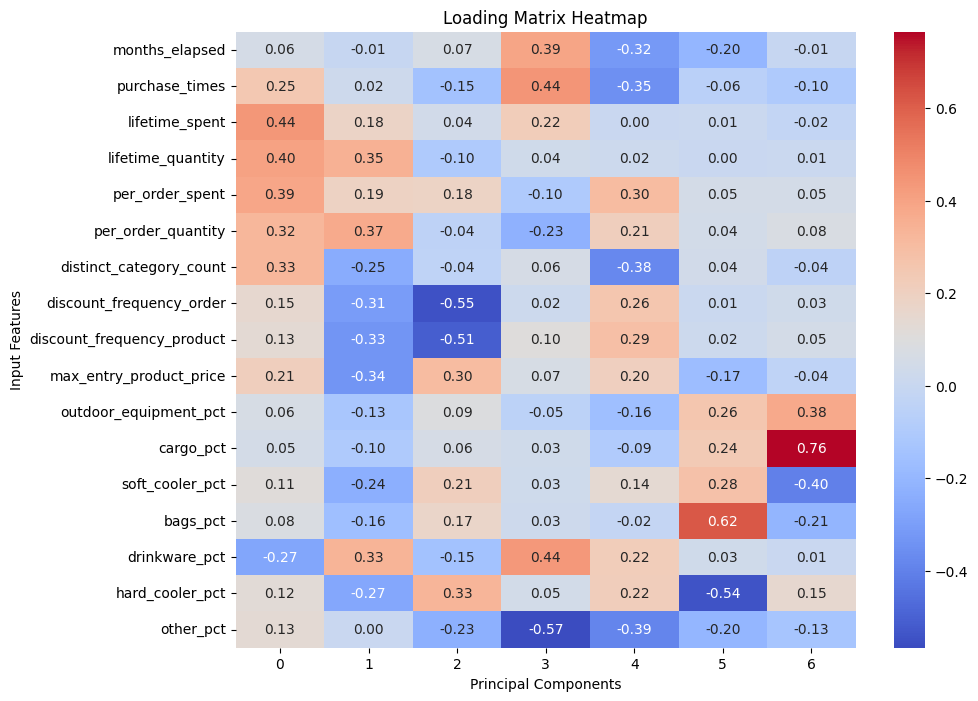

In [7]:
n = 7


# Create a PCA object with 15 components
pca = PCA(n_components=n)

# Fit the PCA model to the standardized data
pca.fit(df2[cols_to_PCA])

# Get the loading matrix with only the first 15 principal components
loading_matrix = pca.components_[:n, :]
# Convert the loading matrix to a Pandas DataFrame
df_loading = pd.DataFrame(data=loading_matrix, columns=cols_to_PCA).T

# Create a heatmap of the loading matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_loading, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Loading Matrix Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Input Features")
plt.show()

In [8]:
# Get the principal component scores for the standardized data
pc_scores = pca.transform(df2[cols_to_PCA])

# Assign the principal component scores back to df2
df2 = df2.reset_index(drop=True)
df2 = pd.concat([df2, pd.DataFrame(data=pc_scores, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])], axis=1)


# K-Mean


## Step 1: Use recency&frequency only, determine churn/no-churn clusters and combine cluster

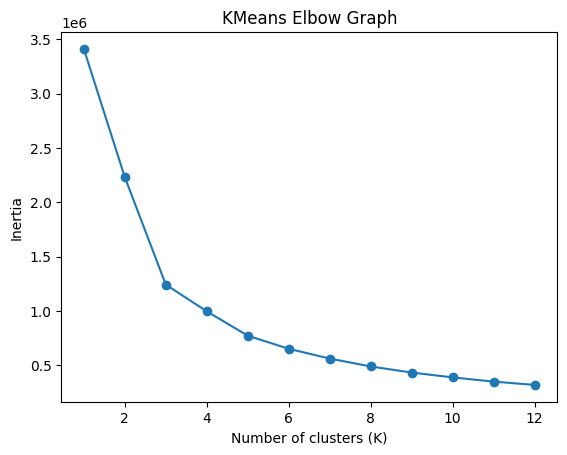

In [14]:
cols_to_kmeans=['avg_time_btw_orders','recency']


# Compute KMeans clustering for K values ranging from 1 to 15
inertias = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df2[cols_to_kmeans])
    inertias.append(kmeans.inertia_)

    # Plot the elbow graph
plt.plot(range(1, 13), inertias, '-o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title(f'KMeans Elbow Graph')
plt.show()

In [10]:
n_cluster = 12
cols_to_kmeans=['avg_time_btw_orders','recency']



# Performe KMeans 
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans1 = kmeans.fit_predict(df2[cols_to_kmeans])

# Attach result back
df2['cluster'] = y_kmeans1

# Unscale the selected columns
unscaled_cols = scaler1.inverse_transform(df2[cols_to_standardize1])

# Create a new DataFrame with unscaled columns and cluster
cluster_1_result = pd.DataFrame(unscaled_cols, columns=cols_to_standardize1)
cluster_1_result["cluster"] = df2["cluster"]

# cluster_x1_result[cols_to_log] = np.expm1(cluster_x1_result[cols_to_log] )

# Compute mean and standard deviation for each cluster
pd.set_option('display.max_columns', None)
cluster_1_result.groupby('cluster').agg({'avg_time_btw_orders': ['count','mean', 'std'], 
                                          'recency': ['mean', 'std'],
                                          **{col: 'mean' for col in cluster_1_result.columns if col not in ['recency', 'avg_time_btw_orders']}}).round(2)



avg_time_btw_orders            recency       months_elapsed  \
                      count  mean  std    mean   std           mean   
cluster                                                               
0                    100877 25.07 3.99    6.63  3.65          43.66   
1                    301100  3.66 2.41    3.51  1.55          21.04   
2                     87900 15.16 4.62   27.56  3.92          52.11   
3                     24139 66.17 9.37   11.84  7.44          78.02   
4                    143364 15.26 4.21   16.00  2.85          43.01   
5                    261189  4.20 2.81   10.12  2.01          24.59   
6                    201419 12.61 2.83    5.10  2.60          34.37   
7                    285157  3.65 2.86   18.42  2.79          28.38   
8                     45532 35.22 7.10   23.74  5.55          63.69   
9                     42098 42.53 5.87    8.59  4.78          56.38   
10                   196794  2.97 2.68   29.23  3.58          36.07   
11                    15525  6.28 6.75   53.93 10.66          64.17   

        purchase_times lifetime_spent lifetime_quantity per_order_spent  \
                  mean           mean              mean            mean   
cluster                                                                   
0                 2.49         271.19              8.40          107.16   
1                 6.09         832.17             28.63          136.86   
2                 2.68         275.93              8.54          101.10   
3                 2.00         232.11              5.07          116.06   
4                 2.82         301.59              9.73          104.65   
5                 4.42         525.19             18.23          119.10   
6                 3.39         395.00             13.32          116.09   
7                 3.60         434.49             14.93          119.62   
8                 2.15         235.50              6.11          108.25   
9                 2.13         240.61              6.72          111.82   
10                3.17         350.10             11.80          105.02   
11                2.94         387.01              9.27          123.98   

        per_order_quantity distinct_category_count discount_frequency_order  \
                      mean                    mean                     mean   
cluster                                                                       
0                     3.40                    2.02                     0.24   
1                     5.04                    2.55                     0.38   
2                     3.23                    1.98                     0.18   
3                     2.54                    1.85                     0.14   
4                     3.46                    2.04                     0.19   
5                     4.26                    2.27                     0.25   
6                     4.01                    2.24                     0.28   
7                     4.24                    2.10                     0.22   
8                     2.85                    1.83                     0.14   
9                     3.17                    1.88                     0.18   
10                    3.70                    1.97                     0.27   
11                    3.05                    1.93                     0.24   

        discount_frequency_product max_entry_product_price  \
                              mean                    mean   
cluster                                                      
0                             0.18                   69.52   
1                             0.28                   79.93   
2                             0.14                   69.29   
3                             0.11                   78.05   
4                             0.14                   68.06   
5                             0.18                   72.99   
6                             0.20                   72.81   
7         

In [8]:
# Rename the 'cluster' column to 'churn'
df2 = df2.rename(columns={'cluster': 'churn'})

# Define a function to replace values
def replace_values(val):
    if val ==0 or val == 1 or val ==3 or val ==6 or val==9:
        return 0
    elif val==2  or val ==5 or val==7 or val==10 or val==11:
        return 1
    else:
        return 'nan'
   

# Use apply to apply the function to the 'cluster' column
df2['churn'] = df2['churn'].apply(replace_values)

### Outcome is 1st target variable: churn(1),no-churn(0), and unsure(nan); increase n_cluster to decrease eunsure(nan) proportion

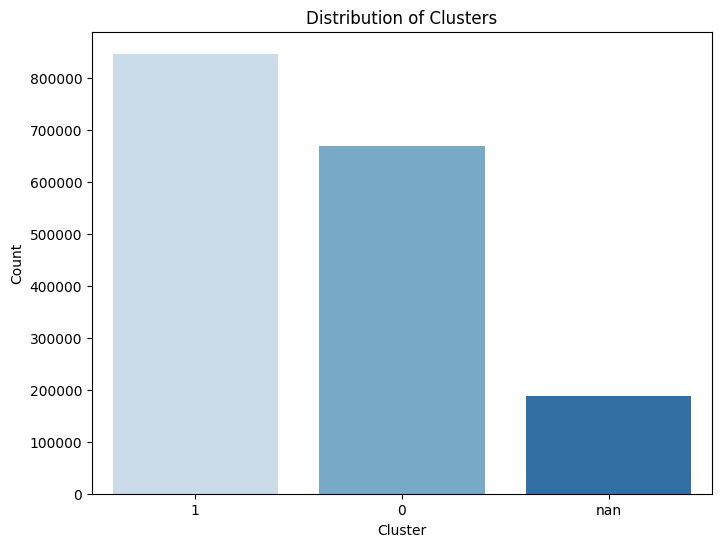

In [32]:
plt.figure(figsize=(8, 6))
cluster_counts = df2['churn'].value_counts()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Blues')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()

## Step2: Use 7 PCA scores, create customer segments soley on purchase history

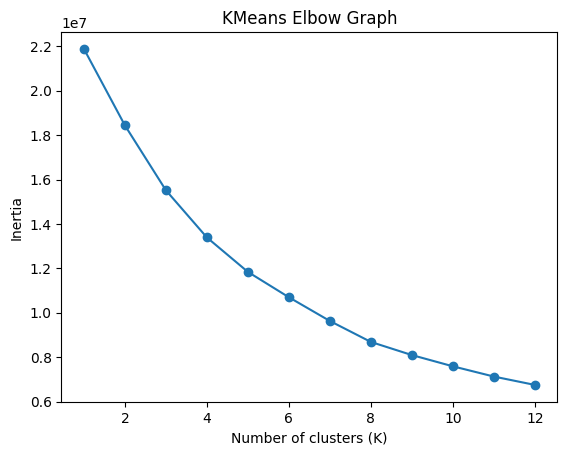

In [9]:
cols_to_kmeans=['PC1','PC2','PC3','PC4','PC5','PC6','PC7']


# Compute KMeans clustering for K values ranging from 1 to 15
inertias = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df2[cols_to_kmeans])
    inertias.append(kmeans.inertia_)

    # Plot the elbow graph
plt.plot(range(1, 13), inertias, '-o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title(f'KMeans Elbow Graph')
plt.show()

In [12]:
n_cluster = 8
cols_to_kmeans=['PC1','PC2','PC3','PC4','PC5','PC6','PC7']


# Performe KMeans 
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans2 = kmeans.fit_predict(df2[cols_to_kmeans])

# Attach result back
df2['cluster'] = y_kmeans2

# Unscale the selected columns
unscaled_cols = scaler1.inverse_transform(df2[cols_to_standardize1])

# Create a new DataFrame with unscaled columns and cluster
cluster_2_result = pd.DataFrame(unscaled_cols, columns=cols_to_standardize1)
cluster_2_result["cluster"] = df2["cluster"]

# cluster_x1_result[cols_to_log] = np.expm1(cluster_x1_result[cols_to_log] )

# Compute mean and standard deviation for each cluster
pd.set_option('display.max_columns', None)
cluster_2_result.groupby('cluster').agg(['mean']).round(2)

# cluster_2_result.groupby('cluster').agg({'months_elapsed': ['mean', 'count'], 
#                                           **{col: 'mean' for col in cluster_2_result.columns if col not in [months_elapsed]}}).round(2)



,avg_time_btw_orders,recency,months_elapsed,purchase_times,lifetime_spent,lifetime_quantity,per_order_spent,per_order_quantity,distinct_category_count,discount_frequency_order,discount_frequency_product,max_entry_product_price,outdoor_equipment_pct,cargo_pct,soft_cooler_pct,bags_pct,drinkware_pct,hard_cooler_pct,other_pct
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,,,,,,,,
0,4.91,8.91,56.54,15.19,2262.19,63.08,175.98,4.99,4.53,0.40,0.32,120.23,0.03,0.02,0.05,0.03,0.56,0.05,0.26
1,13.48,16.08,36.81,2.86,686.38,6.03,242.80,2.05,2.47,0.23,0.20,303.39,0.01,0.00,0.07,0.01,0.32,0.46,0.13
2,12.03,15.50,35.75,3.07,196.08,6.38,63.31,2.05,1.36,0.05,0.04,35.52,0.00,0.00,0.01,0.00,0.94,0.01,0.04
3,11.26,13.43,30.75,2.88,589.11,5.54,205.03,1.88,2.65,0.20,0.17,184.66,0.03,0.00,0.30,0.23,0.31,0.04,0.10
4,10.03,13.55,32.40,3.33,294.86,13.92,90.18,4.38,2.31,0.16,0.09,41.62,0.01,0.00,0.01,0.00,0.52,0.01,0.44
5,11.38,14.66,35.09,3.16,489.67,7.37,154.67,2.30,2.79,0.23,0.20,115.41,0.26,0.27,0.03,0.03,0.24,0.06,0.12
6,7.62,12.49,28.80,3.61,330.54,13.44,94.09,3.92,2.28,0.86,0.68,68.06,0.01,0.00,0.03,0.01,0.64,0.03,0.28
7,5.88,11.47,29.19,6.41,6557.11,313.68,1550.22,80.87,2.47,0.22,0.09,75.44,0.00,0.00,0.03,0.01,0.50,0.02,0.43


In [13]:
result = cluster_2_result.groupby('cluster').agg({ 
                                          **{col: 'mean' for col in cluster_2_result.columns if col not in ['avg_time_btw_orders','recency']},
                                          'cluster': 'count'}).round(2)

result.style.format("{:.2f}").background_gradient(cmap='coolwarm')


,months_elapsed,purchase_times,lifetime_spent,lifetime_quantity,per_order_spent,per_order_quantity,distinct_category_count,discount_frequency_order,discount_frequency_product,max_entry_product_price,outdoor_equipment_pct,cargo_pct,soft_cooler_pct,bags_pct,drinkware_pct,hard_cooler_pct,other_pct,cluster
cluster,,,,,,,,,,,,,,,,,,
0,56.54,15.19,2262.19,63.08,175.98,4.99,4.53,0.40,0.32,120.23,0.03,0.02,0.05,0.03,0.56,0.05,0.26,77738.00
1,36.81,2.86,686.38,6.03,242.80,2.05,2.47,0.23,0.20,303.39,0.01,0.00,0.07,0.01,0.32,0.46,0.13,110393.00
2,35.75,3.07,196.08,6.38,63.31,2.05,1.36,0.05,0.04,35.52,0.00,0.00,0.01,0.00,0.94,0.01,0.04,487282.00
3,30.75,2.88,589.11,5.54,205.03,1.88,2.65,0.20,0.17,184.66,0.03,0.00,0.30,0.23,0.31,0.04,0.10,87096.00
4,32.40,3.33,294.86,13.92,90.18,4.38,2.31,0.16,0.09,41.62,0.01,0.00,0.01,0.00,0.52,0.01,0.44,625394.00
5,35.09,3.16,489.67,7.37,154.67,2.30,2.79,0.23,0.20,115.41,0.26,0.27,0.03,0.03,0.24,0.06,0.12,34193.00
6,28.80,3.61,330.54,13.44,94.09,3.92,2.28,0.86,0.68,68.06,0.01,0.00,0.03,0.01,0.64,0.03,0.28,267864.00
7,29.19,6.41,6557.11,313.68,1550.22,80.87,2.47,0.22,0.09,75.44,0.00,0.00,0.03,0.01,0.50,0.02,0.43,15134.00


* Cluster 0: 'Super Fan'; Oldest customer group, made lots of purchase, spent second highest across most product categories; 
* Cluster 1: 'Hard Cooler Fan'; Infrequent buyers, once and done, first purchase is probably a hard cooler; 
* Cluster 2: 'Drinkware Fan'; Infrequent buyers, low spent, doesn't buy anything but drinkware, 
* Cluster 3: 'Soft Cooler/Bag Fan'; Infrequent buyers, once and done, first purchase is probably a soft cooler or bag; 
* Cluster 4: 'Other Fan'; High quantity on cheap items; 
* Cluster 5: 'Outdoor/Cargo Fan'; Dabble a bit in ~3 categories, least drinkware purchases, 
* Cluster 6: 'Coupon Monster'; Newest customer group, bought a lot discounted drinkware and other items
* Cluster 7: 'Whale'; Newest customer group, High volumn, high purchase times




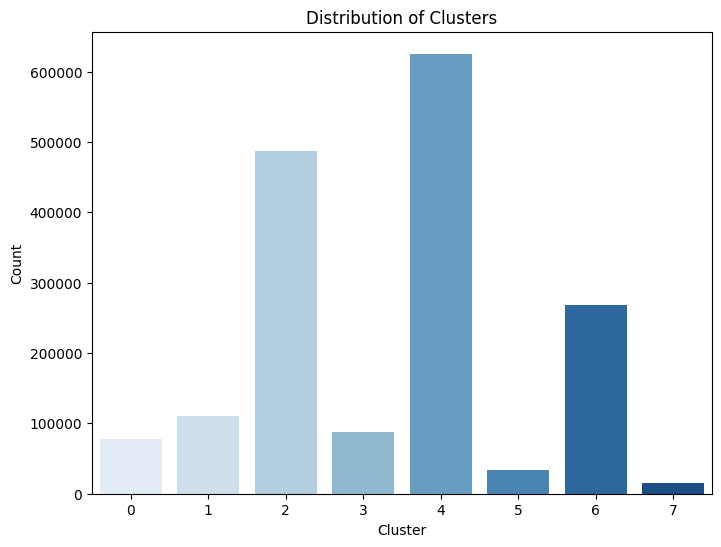

In [35]:
plt.figure(figsize=(8, 6))
cluster_counts = df2['cluster'].value_counts()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Blues')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()

# Undo StandardScaling and Export

In [36]:
df3 = df2.copy()
# Unscale the selected columns
unscaled_cols1 = scaler1.inverse_transform(df2[cols_to_standardize1])
unscaled_cols2 = scaler2.inverse_transform(df2[cols_to_standardize2])

# Replace the scaled values with unscaled values in the original DataFrame
df3.loc[:, cols_to_standardize1] = unscaled_cols1
df3.loc[:, cols_to_standardize2] = unscaled_cols2

In [37]:
df3.head()
df3.to_csv('churn&cluster_v2_04_02.csv')